## Bias-Variance Tradeoff

The [bias–variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) describes the relationship between a model's complexity, the accuracy of its predictions, and how well it can generalize to new data.

The error here is the **expected value** of the test error, which is the expected error of the model when we apply it to new data.

Why **expected value**? 

There is randomness in the training data: we have a random sample from the population, and the model will fit these data differently each time we draw a new sample. Therefore, the model's parameters are also random. We are interested in the average performance of the model over all possible training data.

Suppose the true relationship between the input and output is $y = f(x)$. The fixed testing data is $(x_0, y_0)$.
We collect some data $D = \{(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)\}$. Notice that D is some random sample from the population.
We fit a model to the data, then our model depends on the training data we collected. We denote the fitted model as $\hat{f}(x;D)$.

Then the expected value of the test error is:

<!-- $$E_D[ y - \hat{f}(x;D) ]^2 = E_D[\hat{f}(x;D) - f(x)]^2 + Var_D[\hat{f}(x;D)]$$ -->

$$E_D[ y_0 - \hat{f}(x_0;D) ]^2 = \underbrace{(E_D[\hat{f}(x_0;D)] - y)^2}_{\text{Bias}^2} + \underbrace{Var_D[\hat{f}(x_0;D)]}_{\text{Variance}} $$


The expected value of the test error can be decomposed into 2 parts:

1. **Bias** is the inherent error of the model even with infinite data. For example, the model might assume a linear relationship, but the true relationship is not linear.

2. **Variance** is the error due to the model's sensitivity to the training data. Notice that the training data consists of random samples from the population: if we have a different batch of training data, the model will fit these data differently, and therefore the parameters are different when the training data changes.

If we also consider the noise in the observation, that is, $y_0 = f(x_0) + \epsilon$, where $\epsilon$ is the noise.
Then there will be an additional term in the decomposition, which is called the **irreducible error**. This is the error that we cannot reduce no matter how complex the model is. This error might be due to the noise in the measurement, or other variables that affect the output that we are not measuring.

In general, as we increase the number of tunable parameters in a model, such as the degree of the polynomial, the model becomes more powerful, as it can represent more complex relationships. Then given enough data, the model can recover the true relationship. It is said to have lower bias. 

However, when the data is limited, the more flexible model is also better at fitting the noise in the training data. 
Suppose we encounter a different batch of training data, the model will fit these data differently and make drastically different predictions. It is said to have higher variance.


![tradeoff](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Bias_and_variance_contributing_to_total_error.svg/2880px-Bias_and_variance_contributing_to_total_error.svg.png)




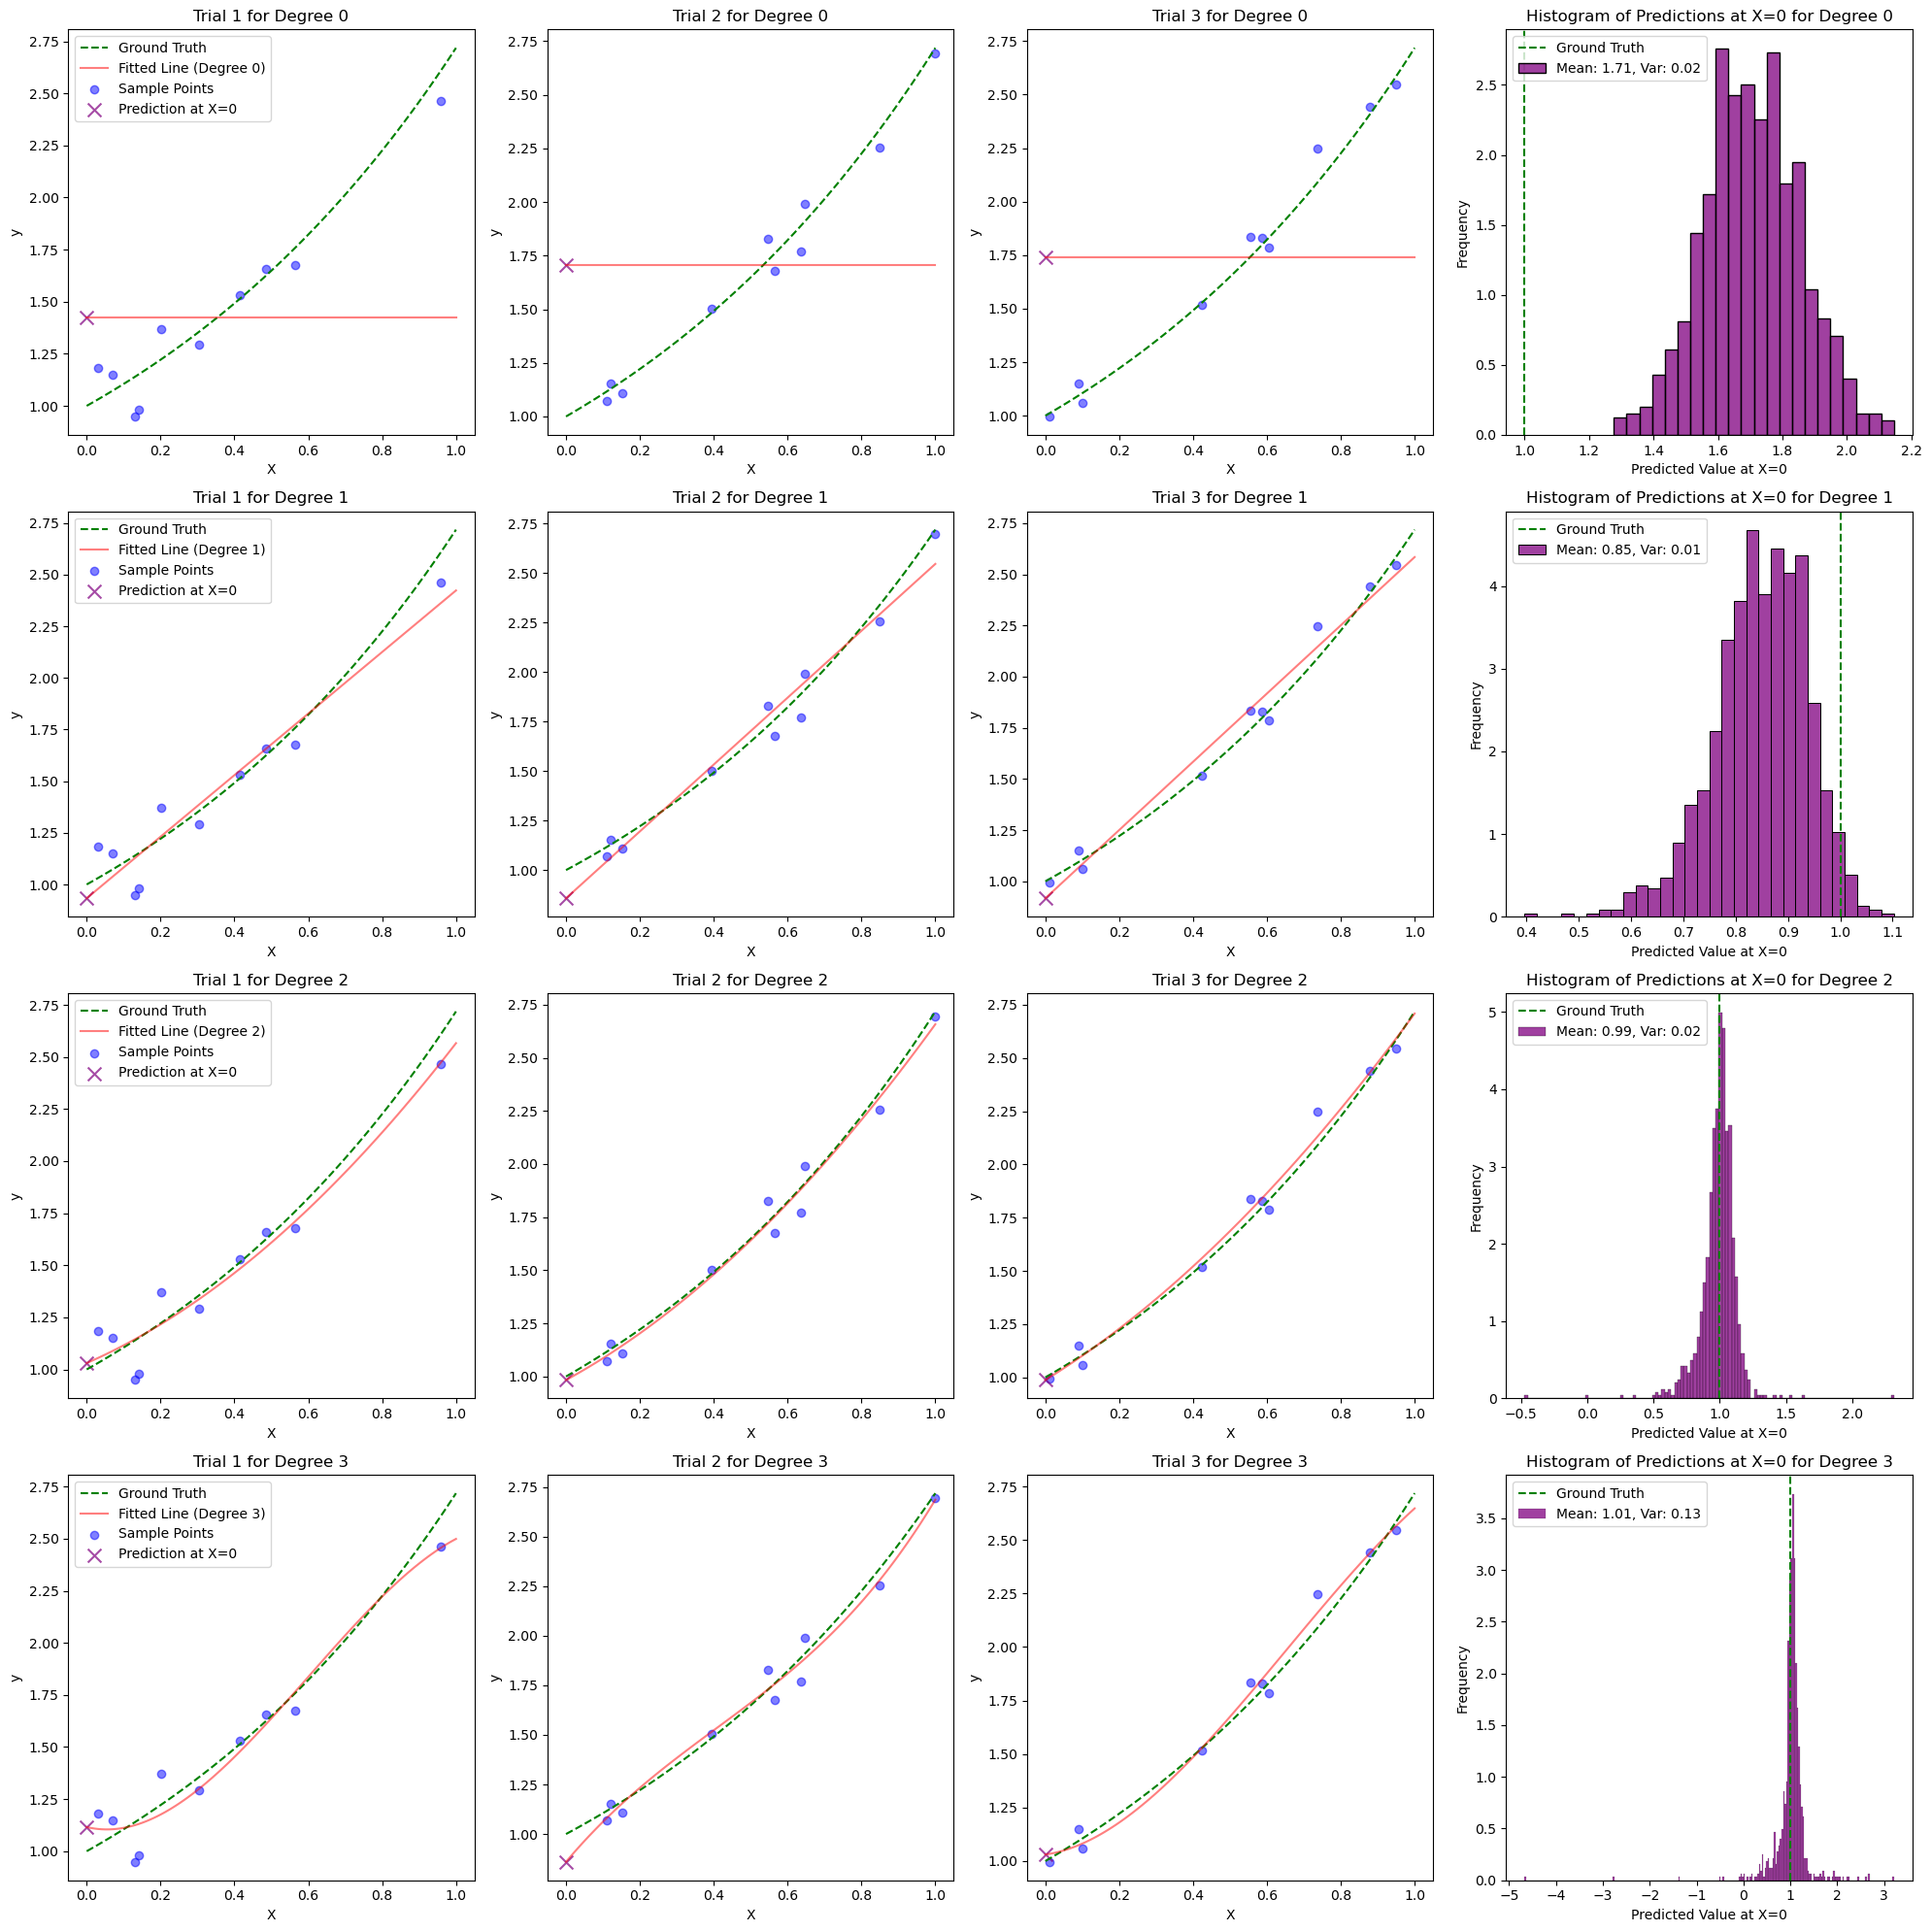

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Generate synthetic dataset
np.random.seed(42)
X = np.linspace(0, 1, 100).reshape(-1, 1)

# random polynomial
fgt = lambda x: np.exp(x)
y = fgt(X) + np.random.normal(0, 0.1, X.shape)


x_gt = 0
# Training data
n = 10
degree_max = 4
num_trials = 1000

# Generate trial-by-n matrix of random points
indices_matrix = np.array([np.random.choice(len(X), n, replace=False) for _ in range(num_trials)])

# Degrees of polynomial to consider
degrees = range(0, degree_max)
point = np.array([[x_gt]])

biases = []
variances = []

fig, axes = plt.subplots(degree_max, 4, figsize=(20, 5 * degree_max))

for degree_idx, degree in enumerate(degrees):
    # Polynomial transformation
    poly_features = PolynomialFeatures(degree=degree)

    # Train linear regression model
    model = LinearRegression(fit_intercept=False)

    predictions = np.zeros(num_trials)
    for trial in range(num_trials):
        # Use pre-generated indices for subsampling training data
        indices = indices_matrix[trial]
        X_train = X[indices]
        y_train = y[indices]

        point_poly = poly_features.fit_transform(point)
        X_train_poly = poly_features.fit_transform(X_train)

        # Fit the model
        model.fit(X_train_poly, y_train)
        predictions[trial] = model.predict(point_poly).item()

        if trial < 3:
            # Intermediate plot - Show the ground truth, sample points, and fitted line for the first 3 trials
            X_poly = poly_features.transform(X)
            y_plot = model.predict(X_poly)

            ax = axes[degree_idx, trial]
            ax.plot(X, fgt(X), color='green', linestyle='--', label='Ground Truth')
            ax.plot(X, y_plot, color='red', alpha=0.5, label=f'Fitted Line (Degree {degree})')
            ax.scatter(X_train, y_train, color='blue', alpha=0.5, label='Sample Points')
            ax.scatter(point, model.predict(point_poly), color='purple', s=100, marker='x', alpha=0.7, label='Prediction at X=0')
            ax.set_xlabel('X')
            ax.set_ylabel('y')
            ax.set_title(f'Trial {trial + 1} for Degree {degree}')
            if trial == 0:
                ax.legend()

    # Plot histogram of predicted values at X = 0 in the last column
    ax_hist = axes[degree_idx, 3]
    sns.histplot(predictions, kde=False, ax=ax_hist, color='purple', stat='density')
    # draw vertical line for the ground truth
    ax_hist.axvline(fgt(x_gt), color='green', linestyle='--', label='Ground Truth')
    ax_hist.set_xlabel('Predicted Value at X=0')
    ax_hist.set_ylabel('Frequency')
    ax_hist.set_title(f'Histogram of Predictions at X=0 for Degree {degree}')
    
    # Add legend for mean and variance
    mean_prediction = np.mean(predictions)
    variance_prediction = np.var(predictions)
    ax_hist.legend([f'Ground Truth', f'Mean: {mean_prediction:.2f}, Var: {variance_prediction:.2f}'])

    expected_prediction = mean_prediction
    bias_squared = (fgt(x_gt) - expected_prediction) ** 2
    variance = variance_prediction

    biases.append(bias_squared)
    variances.append(variance)

plt.tight_layout()
plt.show()




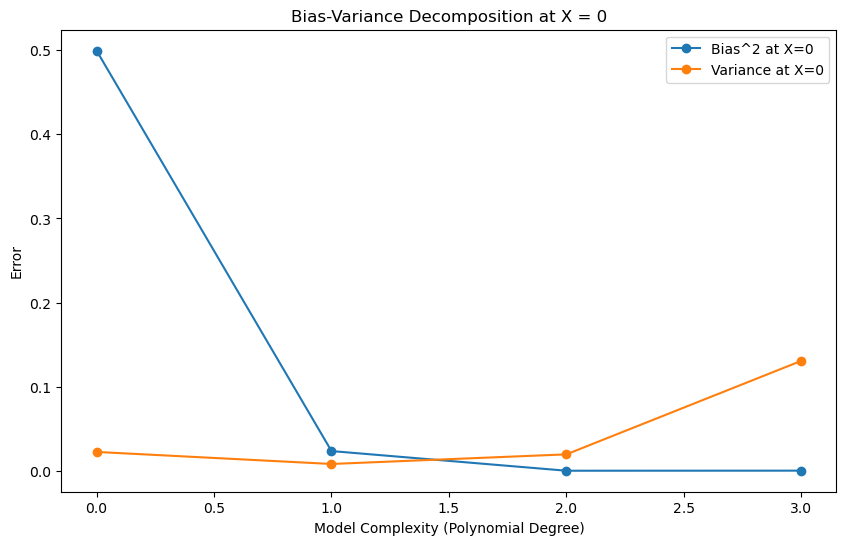

In [23]:
total_errors = np.array(biases) + np.array(variances)   

# Plot bias-variance decomposition
plt.figure(figsize=(10, 6))
plt.plot(degrees, biases, label='Bias^2 at X=0', marker='o')
plt.plot(degrees, variances, label='Variance at X=0', marker='o')
# plt.plot(degrees, total_errors, label='Total Error at X=0', marker='o')
plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('Error')
plt.title('Bias-Variance Decomposition at X = 0')
plt.legend()
plt.show()

## Where is the tradeoff?

The decomposition does not necessarily mean that there is a tradeoff between bias and variance. For some simple families of models, such as polynomials, a more careful analysis can show that the bias decreases and the variance increases as the degree of the polynomial increases. 

But this is not the whole story. See [On the Bias-Variance Tradeoff: Textbooks Need an Update](https://www.bradyneal.com/bias-variance-tradeoff-textbooks-update#suggested-updates-to-textbooks-courses-and-our-mental-models) for more details.
